In [1]:
import numpy as np
import os, pandas
import scipy.io as sio
import pickle 
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.special import expit
from sklearn.metrics import r2_score
from scipy import stats
import statsmodels.formula.api as smf
from IPython.display import Markdown as md
from scipy.stats import gaussian_kde
from sklearn.model_selection import GridSearchCV
from PIL import Image

In [4]:
! conda env export > bonnen_and_eldridge_python_environment.yml

In [5]:
ls 

analyses_and_figures.ipynb
behavioral_data/
bonnen_and_eldridge_python_environment.yml
stimuli/
within-subject_reliability_50_iterations.csv


In [2]:
import warnings; warnings.filterwarnings('ignore')

In [3]:
save_to_pdf = 0

In [4]:
def get_masked_indices(): 
    f = open("stimuli/imageFiles_1100-1.txt", "r")
    mask_morphs_indices = [i[1:-2] for i in f.read().splitlines()]
    f.close() 
    return mask_morphs_indices

In [5]:
def extract_behavioral_data(): 
    """
    example data format--converted from .mat files: 
        > experiment_data = behavioral_data[ list(behavioral_data)[2]   ]
        > experiment_data.shape
        (440, 18, 8, 9)
        
    where
    - 440 = unique stimuli
    - 18 = data containing array where 
    ---- indices 4-14 morph level coded as 1-hot vector 
    ----      i.e. [0 1 0 0 0 0 0 0 0 0 0] =  10% dog morph 
    ----      i.e. [0 0 0 0 0 0 0 0 0 0 1] = 100% dog morph 
    - 8 = sessions/days
    - 9 = monkeys    
    """
    # 
    data_path = 'behavioral_data/'#single_trial_data_2021.1.16/'
    # import names of files
    data_files = [i for i in os.listdir(data_path) if 'DS' not in i]
    # all imported files 
    behavioral_data = {i[:-4]: sio.loadmat(os.path.join(data_path,i))['raw_data'] for i in data_files}
    # formatting :/ 
    stimuli_path = 'stimuli/eLife_stim/'
    stim_folders = [i for i in os.listdir(stimuli_path) if 'Exp' in i]
    stim_files = {i: [i for i in os.listdir(os.path.join(stimuli_path, i)) if 'DS' not in i] for i in stim_folders}
    stim_files = {i: np.sort(stim_files[i]) for i in stim_files}
    mask_morph_indices = get_masked_indices()     
    
    naming = {'Exp2_central_bias': 'central_biased_morphs', 
              'Exp4_crossed_morphs': 'crossed_morphs', 
              'Exp1_linear_distribution': '10pct_spaced_morphs',
              'Exp3_masked_morphs': 'masked_morphs', 
              'central_biased_morphs': 'Exp2_central_bias',
              'crossed_morphs':'Exp4_crossed_morphs', 
              '10pct_spaced_morphs':'Exp1_linear_distribution',
              'masked_morphs':'Exp3_masked_morphs'}
    
    stim_files = {naming[i]: stim_files[i] for i in stim_files}
    
    percent_map = {
         '10pct_spaced_morphs': np.array([0,10,20,30,40,50,60,70,80,90,100]),
         'central_biased_morphs': np.array([0,25,35,40,45,50,55,60,65,75,100]),
         'masked_morphs': np.array([0,25,  35,  40,  45,  50,  55,  60,  65,  75, 100]),
         'crossed_morphs': np.array([0,10,20,30,40,50,60,70,80,90,100])}
    
    lesion_map = {0:'CON', 1:'CON', 2:'CON', 3:'TE', 4:'TE', 5:'TE', 6:'PRC', 7:'PRC', 8:'PRC'}
    
    name_map = {0:0,1:1,2:2,3:6,4:7,5:8,6:3,7:4,8:5}
    
    # initialize dataframe 
    df = pandas.DataFrame() 
    
    for e in evaluation_experiments:

        experiment = behavioral_data[ e ]

        for subject in range(experiment.shape[3]): 
        
            for day in range(experiment.shape[2]): 

                # extract all experimental data for this day
                day_data = experiment[:,:,day, subject]
                # only keep trials where there is RT data (i.e. there's a responses)--marked as 0 otherwise
                day_data = day_data[ day_data[:,1] > 0, :]

                if 'masked_morphs' in e: 
                    ids = [int(i-1) for i in day_data[:, 5]] # FIXED? 
                    image_name = [mask_morph_indices[i] for i in ids]
                    mask_FROM_IMAGE = [i[-6:-4] for i in image_name] 
                    percent = [percent_map[e][int(i-1)] for i in day_data[:, 4]] 
                    mask_FROM_MAT = day_data[:, 3]  
                    response = day_data[:, 6]
                    correct = (np.array(percent) > 50) * (response) 
                    PERCENT_FROM_IMAGE = [int(i[11:14]) for i in image_name]
                    ground_truth = (np.array(percent) >= 50)
                    
                else: 
                    # all indices from personal correspondence
                    ids = [int(i-1) for i in day_data[:, -1]]
                    response = day_data[:,14]
                    # extract all columns that have information related to the percent morph level
                    percent_indices = np.array([day_data[i,3:14] for i in range(day_data.shape[0])])
                    percent = np.array([percent_map[e][int(i)] for i in percent_indices.argmax(1) ])
                    image_name = [stim_files[e][i] for i in ids]
                    PERCENT_FROM_IMAGE = [int(i[11:14]) for i in image_name]
                    ground_truth = (np.array(percent) >= 50)
                    #ground_truth[percent==50] = np.random.randint(0,2, sum(percent==50))
 
                tiny_df = pandas.DataFrame({
                    'group': np.repeat(lesion_map[subject], day_data.shape[0]),
                    'subject': np.repeat(name_map[subject], day_data.shape[0]), 
                    'experiment': np.repeat(e, day_data.shape[0]),
                    'day': np.repeat(day, day_data.shape[0]), 
                    'trial': range(day_data.shape[0]), 
                    'percent': percent, 
                    'percent_CHECK': PERCENT_FROM_IMAGE, 
                    'image_id': ids, 
                    'image': image_name, 
                    'ground_truth': ground_truth,
                    'choice': response,    
                    'correct': ground_truth == response
                    })

                df = df.append(tiny_df, ignore_index=True)
            
    # remove all trials where images (via the stimulus ID)
    df = df[df.percent==df.percent_CHECK]
    df = df[df.group!='TE']
    
    return df[[i for i in df.columns if 'CHECK' not in i]]

In [6]:
def load_representations(representations): 
    
    """Load stimuli representations"""
    
    if representations=='vgg': 
        # load a VVS model responses previously collected from all stimuli
        with open('stimuli/model_responses.pkl', 'rb') as f:
            representations = pickle.load(f)  
        print('loaded vgg representations')
            
    elif representations == 'pixels':  
        # load pixel "representations" -- i.e. load images and vectorize them
        base_directory = './stimuli/eLife_stim/'
        stimulus_directories = [i for i in os.listdir(base_directory) if '.DS_Store' not in i]
        
        representations  = {} 

        for i_directory in stimulus_directories: 

            path_to_directory = os.path.join(base_directory, i_directory)
            stimulus_files = np.sort( [i for i in os.listdir(path_to_directory) if '.pcx' in i] ) 

            representations[i_directory] = {} 

            for i_file in  stimulus_files: 

                i_image = Image.open(os.path.join(path_to_directory, i_file))
                representations[i_directory][i_file] = np.array(i_image).flatten()
        
        print('loaded pixel representations')
        
    return representations

In [7]:
def determine_model_performance_main(df, representations, n_iterations): 
    
    naming = {'Exp2_central_bias': 'central_biased_morphs', 
              'Exp4_crossed_morphs': 'crossed_morphs', 
              'Exp1_linear_distribution': '10pct_spaced_morphs',
              'Exp3_masked_morphs': 'masked_morphs', 
              'central_biased_morphs': 'Exp2_central_bias',
              'crossed_morphs':'Exp4_crossed_morphs', 
              '10pct_spaced_morphs':'Exp1_linear_distribution',
              'masked_morphs':'Exp3_masked_morphs'}
    
    def make_column(x, test_df): return np.repeat(x, len(test_df))
            
    np.random.seed(random_seed)
    readouts = {'logistic': LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=5000)}

    train_test_ratio = 4/5
    analysis_level = 'image'
    target = 'ground_truth'
    model_type = 'logistic'
    
    df_model = pandas.DataFrame()

    for i_test in evaluation_experiments:

        exp_df = df[df.experiment==i_test]
        
        # model representations
        if i_test == 'masked_morphs': 
            X = [representations[naming[i_test]][i] for i in get_masked_indices() ]             
        else: 
            X = [representations[naming[i_test]][i] for i in representations[naming[i_test]].keys() ] 
        
        for i_iteration in range(n_iterations):
            
            print(i_iteration, end='')
            
            random_order = np.random.permutation(range(len(X)))
            i_split = int(len(random_order)*(train_test_ratio))

            train = exp_df[ [i in random_order[:i_split] for i in exp_df.image_id.values] ] 
            test  = exp_df[ [i in random_order[i_split:] for i in exp_df.image_id.values] ] 

            train = train.groupby(analysis_level, as_index=False).mean()
            test  = test.groupby(analysis_level, as_index=False).mean()

            x_train = np.array([X[int(i-1)] for i in train.image_id.values])
            x_test  = np.array([X[int(i-1)] for i in test.image_id.values])
            
            readouts[model_type].fit(x_train, train[target].values)
            model_predictions =  readouts[model_type].predict(x_test)

            # bookkeeping
            i_df = pandas.DataFrame({
                        'group': make_column('model', test), 
                        'experiment': make_column(i_test, test),
                        'iteration': make_column(i_iteration, test), 
                        'percent': test.percent.values, 
                        'image_id': test.image_id.values, 
                        'image': test.image.values, 
                        'ground_truth': 1 * (test.percent.values >= 50),
                        'analysis_level': make_column(analysis_level, test), 
                        'target': make_column(target, test), 
                        'choice': model_predictions, 
                        'correct': np.array(model_predictions) == (1 * (test.percent.values >= 50)), 
                        'y': test[target].values
                        })

            df_model = df_model.append(i_df, ignore_index=True)
    
    return df_model

In [8]:
def show_model_monkey_correspondence(df, df_m): 
    
    fontsize = 14 
    
    colorscheme = {'CON':'#441580',
                   'CON':'#7123d4',
                   'PRC':'#01b282', 
                   'model':'black'}

    LR = LogisticRegression(solver='lbfgs')
    iplot=1

    nice_names = {'10pct_spaced_morphs': '10% Spaced Morphs', 
     'central_biased_morphs': 'Central Biased Morphs', 
     'masked_morphs': 'Masked Morphs', 
     'crossed_morphs': 'Crossed Morphs', 
    }
    
    def colorFader(c1,c2,mix=0): 
        # https://stackoverflow.com/questions/25668828/how-to-create-colour-gradient-in-python
        c1=np.array(mpl.colors.to_rgb(c1))
        c2=np.array(mpl.colors.to_rgb(c2))
        return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

    lcolors = {'PRC': colorscheme['PRC'], 
               'CON': colorscheme['CON'], 
               'model':'black'}
    
    lesion_groups = ['CON', 'PRC']
    naming = {'CON':'PRC Intact', "PRC":'PRC Lesion', }
    
    ################################# SUBJECT
    
    for e in nice_names:
        
        for i_group in lesion_groups: 
            
            ax = plt.subplot(len(df.experiment.unique()), len(lesion_groups)+2, iplot)
            
            if iplot in [1, 2, 3, 4]: 
                plt.text(-.1, 1.05, ['a', 'b', 'c', 'd'][(iplot-1)], fontsize=12,
                     fontweight='bold', transform=ax.transAxes,)

            if iplot in [1, 5, 9, 13]: 
                plt.ylabel('Proportion Identified as Dog\n%s'%nice_names[e], fontsize=fontsize) 
                plt.text(-.9, .5, 'Experiment %d'%(np.nonzero(np.array(list(nice_names))==e)[0][0] + 1),                          
                         fontsize=fontsize, transform=ax.transAxes,)
            
            
            group_data = df[(df.group==i_group)*(df.experiment==e)]
            n_days = len(group_data.day.unique())

            for i_day in range(n_days):         

                i_color = colorFader('black',colorscheme[i_group],i_day/n_days)
                day_data = group_data[group_data.day==i_day]
                clf = LR.fit(np.expand_dims(day_data.percent,1), day_data.choice)
                X_lims = np.linspace(0, 100, 100).round(0)
                loss = expit(X_lims * clf.coef_ + clf.intercept_).ravel()
                plt.plot(X_lims, loss, linewidth=1, 
                         color=i_color)

                i_behavior = day_data.groupby(['percent'], as_index=False).mean() 
                plt.scatter(x=i_behavior.percent, y=i_behavior.choice, 
                            facecolor='', s=10, linewidth=.5, edgecolor=i_color)

                plt.scatter([], [], color=i_color, label='Repeat %d'%i_day)
            
            if e == df.experiment.unique()[-1]: 
                plt.xlabel('Morph Level (% Dog)', labelpad=10, fontsize=fontsize)
            elif e == list(nice_names)[0]: 
                plt.title('%s Group Behavior\n'%naming[i_group], y=1.05, fontsize=fontsize)
                
            plt.legend(loc=4, framealpha=0, fontsize=9, title_fontsize=9, 
                      # title='Experiment %d'%(((iplot-1)//4)+1)
                      )
            iplot+=1
            plt.ylim(-.05, 1.05)
        
        ####################################### MODEL PERFORMANCE ACROSS %s
        ax = plt.subplot(len(df.experiment.unique()), len(lesion_groups)+2, iplot)
                
        for i_iteration in df_m.iteration.unique(): 
            i_df = df_m[(df_m.iteration==i_iteration)&(df_m.experiment==e)]
            iteration_data = i_df.groupby(['percent'], as_index=False).mean()
            try: 
                clf = LR.fit(np.expand_dims(i_df.percent.values,1), i_df.choice.values)
            except: 
                choice_values = i_df.choice.values >= .5 
                clf = LR.fit(np.expand_dims(i_df.percent.values,1), choice_values)
            X_lims = np.linspace(0, 100, 100).round(0)
            loss = expit(X_lims * clf.coef_ + clf.intercept_).ravel()
            plt.plot(X_lims, loss, color=colorscheme['model'], linewidth=2, alpha=.1)
        
        plt.plot([], [], color=colorscheme['model'], linewidth=2, alpha=.3, 
                 label='  Single\nIteration'
                )
        
        try: 
            clf = LR.fit(np.expand_dims(df_m.percent.values,1), df_m.choice.values)
        except: 
            print('!')
            choice_values = df_m.choice.values >= .5 
            clf = LR.fit(np.expand_dims(df_m.percent.values,1), choice_values)
        
        X_lims = np.linspace(0, 100, 100).round(0)
        loss = expit(X_lims * clf.coef_ + clf.intercept_).ravel()
        #plt.plot(X_lims, loss, color=colorscheme['model'], linewidth=1, alpha=1, label='Average')
        plt.legend(loc=4, framealpha=0, fontsize=9, 
                   #title='Experiment %d\n     Iteration'%(((iplot-1)//4)+1),
                   title_fontsize=9)
        
        if iplot ==3: 
            #plt.text(-.1, 1.05, 'c', fontsize=12, fontweight='bold', transform=ax.transAxes,)
            plt.title('VVS Model Behavior\n', y=1.05, fontsize=fontsize)
            plt.text(-.1, 1.05, 'c', fontsize=12, fontweight='bold', transform=ax.transAxes,)
            
        iplot+=1
        
        
        if e == df.experiment.unique()[-1]: 
            plt.xlabel('Morph Level (% Dog)', labelpad=10, fontsize=fontsize)
        
        res = 'group'
        target = 'percent'
        alpha=1
        s = 40
        #################################### MODEL FIT TO GROUP BEHAVIOR 
        for group in ['CON', "PRC"]: 
            
            ax = plt.subplot(len(df.experiment.unique()), len(lesion_groups)+2, iplot)
            
            igroup = df[(df[res]==group)&(df.experiment==e)]
            imodel = df_m[df_m.experiment==e].groupby(target, as_index=False)
            igroup = igroup.groupby(target, as_index=False)

            plt.scatter(x=imodel.mean().choice.values, 
                        y=igroup.mean().choice, 
                        facecolor=colorscheme[group],
                        edgecolor='black', alpha=1, s=s, 
                        linewidth=.5, label=naming[group], zorder=1)

            EB = plt.errorbar(x=imodel.mean().choice.values, 
                              y=igroup.mean().choice, 
                              xerr=(imodel.std().choice.values)/2, 
                              yerr=(igroup.std().choice.values)/2,
                              color=colorscheme[group], linestyle='', 
                              alpha=.3, 
                              elinewidth=1, 
                              zorder=-1) 

            [EB[-1][i].set_linestyle('-') for i in [0, 1]]

           
        plt.plot([0, 1], [0, 1], color='grey', linestyle='--', linewidth=.5, zorder=-2, alpha=.3)
        plt.legend(framealpha=0, title='Model fit to group', fontsize=9, title_fontsize=9) 
        plt.xlim([-.15, 1.15])
        plt.ylim([-.15, 1.15])
        
        if e == list( nice_names )[-1]: 
            plt.xlabel('VVS Model Behavior\n', labelpad=10, fontsize=fontsize)
            
        if iplot ==4: 
            plt.title('Model Correspondence\n with Group Behavior', y=1.05, fontsize=fontsize)
            plt.text(-.1, 1.05, 'd', fontsize=12, fontweight='bold', transform=ax.transAxes,)
            
        iplot+=1

In [9]:
def show_model_parameters(m_, idx_ =-1, markdown=False):
    """prints pretty markdown stats results or latex-style formatting"""
    # fit model 
    m_ = m_.fit() 
    # extract significant figures from float 
    def sigfigs(x):
        if x>0: 
            d = int(str('%.2e'%x)[('%.2e'%x).find('-')+1:])
            n = np.round(float(str('%.02e'%x)[0:3]))
            return n, d
        else: 
            return x, x
    
    # extract model parameters 
    beta, pval, df_model = m_.params[idx_], m_.pvalues[idx_], m_.df_model
    rsqrd, df_resid, tvalues = m_.rsquared, m_.df_resid, m_.tvalues[idx_]
    
    sigfigs(pval)
    # show exact p values up to three significant figures 
    if sigfigs(pval)[1] < 4:
        stat_str = "$R^{2} = %.02f$ $\\beta = %.2f$, $F(%d, %d)$ = $%.02f, P = %.03f $"
        report = stat_str%(rsqrd, beta, df_model, df_resid, tvalues, pval, )
    else:
        stat_str = "$R^{2} = %.02f$ $\\beta = %.2f$, $F(%d, %d)$ = $%.02f, P = %.0f $ x $ 10 ^{-%d} $"
        report = stat_str%(rsqrd, beta, df_model, df_resid, tvalues, sigfigs(pval)[0], sigfigs(pval)[1])
    
    if markdown: 
        REPORT = md(report)
    else: 
        REPORT = report 

    # return markdown visualization 
    return  REPORT

In [10]:
n_iterations = 50

In [11]:
random_seed = np.random.seed(n_iterations)

In [12]:
evaluation_experiments = ['central_biased_morphs', '10pct_spaced_morphs', 'masked_morphs', 'crossed_morphs']

In [13]:
monkey = extract_behavioral_data()

In [14]:
model = load_representations('vgg')

loaded vgg representations


In [15]:
model_performance = determine_model_performance_main(monkey, model, n_iterations)

012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849

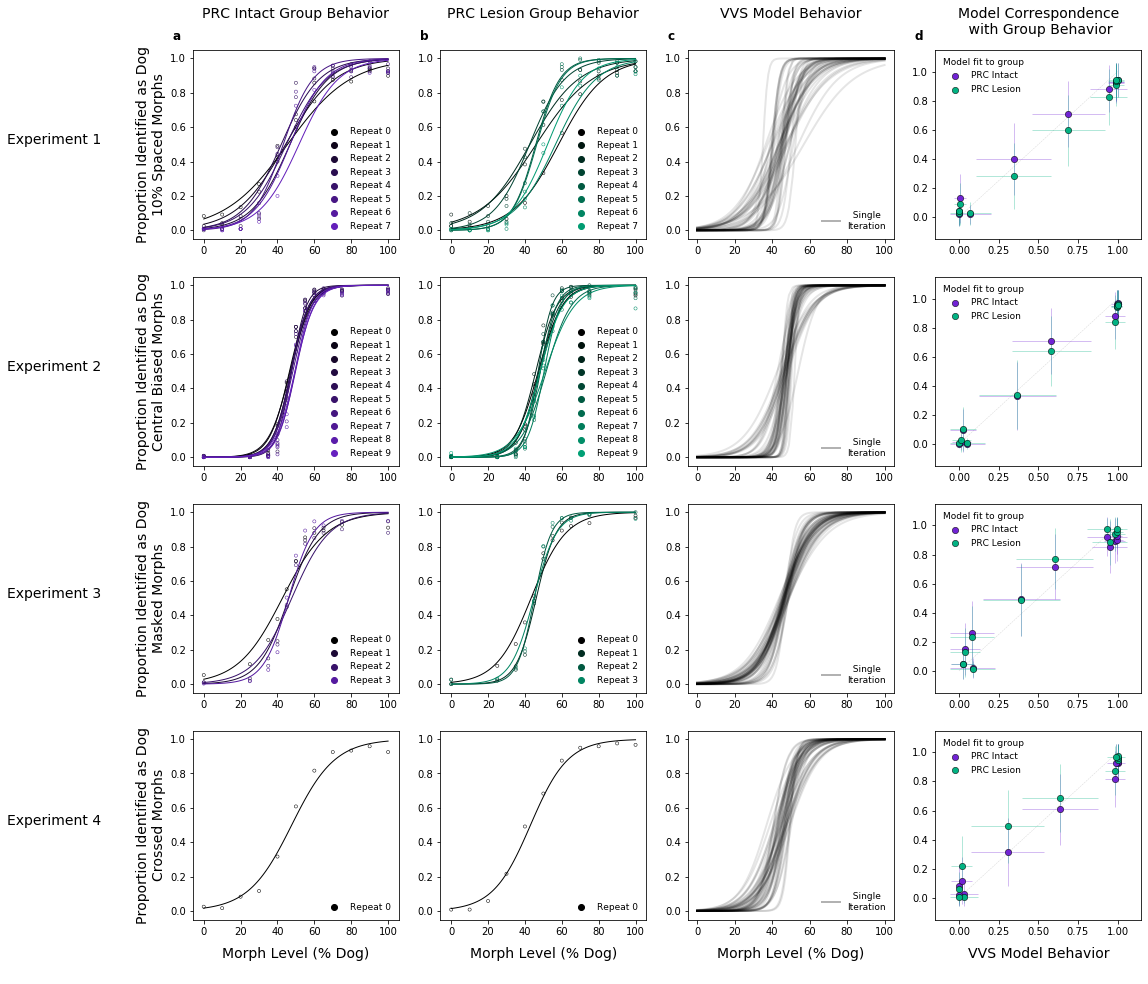

In [16]:
plt.figure(figsize=[17, 16])
show_model_monkey_correspondence(monkey, model_performance) 
if save_to_pdf: plt.savefig('main_analysis.pdf', bbox_inches = "tight", format='pdf')

# some stats

In [17]:
show_model_parameters(smf.ols('choice ~ group * percent',data=monkey.groupby(['group',
                                                                              'experiment', 
                                                                              'percent'], 
                                                                             as_index=False).mean()),
                      markdown=True) 

$R^{2} = 0.81$ $\beta = 0.00$, $F(3, 84)$ = $0.19, P = 0.851 $

In [18]:
group_behaviors = pandas.DataFrame(
    {'PRC_lesion': monkey.groupby(['experiment', 'percent']).mean().choice.values, 
     'PRC_intact': monkey.groupby(['experiment', 'percent']).mean().choice.values, 
     'model_predictions': model_performance.groupby(['experiment', 'percent']).mean().choice.values})

In [19]:
show_model_parameters( smf.ols('PRC_lesion ~ model_predictions', data=group_behaviors),markdown=True) 

$R^{2} = 0.98$ $\beta = 0.90$, $F(1, 42)$ = $44.03, P = 9 $ x $ 10 ^{-37} $

In [20]:
show_model_parameters( smf.ols('PRC_intact ~ model_predictions', data=group_behaviors),markdown=True) 

$R^{2} = 0.98$ $\beta = 0.90$, $F(1, 42)$ = $44.03, P = 9 $ x $ 10 ^{-37} $

In [21]:
group_behaviors = pandas.DataFrame(
    {'human': monkey.groupby(['group', 'experiment', 'percent']).mean().choice.values, 
     'group': monkey.groupby(['group', 'experiment', 'percent'], as_index=False).mean().group.values,
     'model_predictions': np.repeat(
         [model_performance.groupby(['experiment','percent']).mean().choice.values], 2, axis=0).flatten() 
    })

show_model_parameters( smf.ols('human ~ group * model_predictions', data=group_behaviors),markdown=True) 

$R^{2} = 0.98$ $\beta = 0.01$, $F(3, 84)$ = $0.35, P = 0.727 $

In [22]:
subject_behaviors = monkey.groupby(['group', 'subject', 'experiment', 'percent'], as_index=False).mean() 

In [23]:
show_model_parameters(smf.ols('subject1 ~ model', data={
    'subject1': subject_behaviors[subject_behaviors.subject==1].choice.values, 
    'model': model_performance.groupby(['experiment', 'percent']).mean().choice.values}), markdown=True) 

$R^{2} = 0.96$ $\beta = 0.89$, $F(1, 42)$ = $32.51, P = 2 $ x $ 10 ^{-31} $

In [24]:
show_model_parameters(smf.ols('subject4 ~ model', data={
    'subject4': subject_behaviors[subject_behaviors.subject==4].choice.values, 
    'model': model_performance.groupby(['experiment', 'percent']).mean().choice.values}), markdown=True) 

$R^{2} = 0.96$ $\beta = 0.92$, $F(1, 42)$ = $30.71, P = 2 $ x $ 10 ^{-30} $

# reliability analyses

In [25]:
def within_subject_splithalf_reliability(n_iterations=50): 
    
    np.random.seed(random_seed)

    def split_means(v): 
        v = np.random.permutation(v)
        return v[:len(v)//2].mean(), v[len(v)//2:].mean()

    reliability = pandas.DataFrame()

    for subject in df.subject.unique(): 

        subject_df = df[df.subject==subject]

        for e in reliability_experiments: 

            i_df = subject_df[subject_df.experiment==e]

            for i_iteration in range(n_iterations): 

                splits = [split_means(i_df[i_df.image==i].choice.values) for i in np.sort(i_df.image.unique())]
                both_splits = np.array(splits).T.flatten() 
                percent = [i_df[i_df.image_id==i].percent.values[0:2] for i in np.sort(i_df.image_id.unique())]
                splits_correct = [split_means(i_df[i_df.image==i].correct.values) for i in np.sort(i_df.image.unique())]
                both_correct = np.array(splits).T.flatten()

                iteration_df = pandas.DataFrame(
                    {'group': [i_df.group.values[0] for i in range(len(both_splits))],
                     'subject':  np.repeat(subject, len(both_splits)),
                     'experiment': np.repeat(e, len(both_splits)),
                     'percent': np.array(percent).T.flatten(),
                     'image': np.array([(i, i) for i in np.sort(i_df.image.unique())]).T.flatten() , 
                     'iteration': np.repeat(i_iteration, len(both_splits)),
                     'split':np.array([(1, 2) for i in range(len(splits))]).T.flatten() ,
                     'choice':both_splits, 
                     'correct': both_correct, 
                     'split_r': np.corrcoef(np.array(splits)[:,1], np.array(splits)[:,0])[0,1], 
                     'split_r2': r2_score(np.array(splits)[:,1], np.array(splits)[:,0]), 
                    })

                reliability = reliability.append(iteration_df, ignore_index=True)

    return reliability

In [26]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def show_values(grid, ax, th=.8): 
    for (j,i),label in np.ndenumerate(grid):
        #if j<=i: 
        ax.text(i, 
                j, 
                np.round(label,2) ,
                ha='center',
                va='center', 
                size=9, 
                #fontweight='bold',
                color=['black','white'][1*(label<th)])
    imin = -.5
    imax = .5+j
    
    plt.xticks(np.arange(0,j+1), np.arange(0,j+1))
    plt.yticks(np.arange(0, j+1,), np.arange(0,j+1))
    plt.ylim(imax, imin)
    plt.xlim(imin, imax)
    
    i_color = 'white'
    i_width=2

    if j<4:
        plt.xlabel('GROUP')
    else: 
        plt.xlabel("SUBJECT")

In [27]:
reliability_experiments = ['central_biased_morphs', '10pct_spaced_morphs'] 

In [28]:
load_reliability_from_file = True

if load_reliability_from_file: 
    df_reliability = pandas.read_csv('within-subject_reliability_50_iterations.csv')
else: 
    # takes a while 
    df_reliability  = within_subject_splithalf_reliability(n_iterations=n_iterations)
    df_reliability.to_csv('within-subject_reliability_%d_iterations.csv'%n_iterations)

In [29]:
def model_subject_correspondence(df, df_r, df_m1, resolution='subject', target='image'): 

    sort = np.sort
    def bound(vector, MIN=0, MAX=100, SCALE=100): 
        return np.array([max(min(i*SCALE, MAX), MIN) for i in vector])

    def BOUND(vector, MIN=0, MAX=1, SCALE=1): 
        return np.array([max(min(i*SCALE, MAX), MIN) for i in vector])

    resolution = 'subject'
    target = 'image'
    TARGET = 'percent'
    df_r = df_reliability
    elements = list( sort(df[resolution].unique()) )
    matrix = np.zeros([len(elements), len(elements)])
    ncols = len(elements)+3
    nrows = len(elements)
    pointsize = 5
    ticksize  = 8 
    labelsize = 10
    onalpha   = .9
    offalpha  = .6
    linewidth = .5
    maxp = 101 
    minp = -1 

    LWIDTH=.5
    POINTSIZE = 40
    colorscheme = {'central_biased_morphs': {'CON':'#441580','PRC':'#128e80', 'model':'black'}, 
                   '10pct_spaced_morphs': {'CON':'#441580','PRC': '#01b282', 'model':'grey'}, 
                   'masked_morphs': {'CON':'#441580','PRC': '#01b282', 'model':'grey'}
                  }

    for e in ['central_biased_morphs', '10pct_spaced_morphs']: 

        iplot = 1         
        ae = df[(df.experiment==e)]
        aer = df_r[(df_r.experiment==e)]
        m1e = df_m1[(df_m1.experiment==e)]
        #m2e = df_m2[(df_m2.experiment==e)]

        for m in elements: 

            x = ae[ae[resolution]==m].groupby(target).mean().choice.values
            X = ae[ae[resolution]==m].groupby(TARGET).mean().choice.values

            for n in elements: 


                if m == n: 
                    nits = 2
                    maer = aer[aer[resolution]==m]
                    x = maer[(maer.split==1)&(maer.iteration<nits)].groupby([target]).mean().choice.values 
                    y = maer[(maer.split==2)&(maer.iteration<nits)].groupby([target]).mean().choice.values 

                    Y = maer[(maer.split==2)&(maer.iteration<nits)].groupby([TARGET]).mean().choice.values 
                    X = maer[(maer.split==1)&(maer.iteration<nits)].groupby([TARGET]).mean().choice.values 
                    alpha=onalpha
                else: 
                    y = ae[ae[resolution]==n].groupby([target]).mean().choice.values 
                    Y = ae[ae[resolution]==n].groupby([TARGET]).mean().choice.values 
                    alpha=offalpha

                ax = plt.subplot(nrows, ncols, iplot)
                plt.xticks([]); 
                plt.yticks([]); 

                if n == elements[0]: 
                    plt.ylabel([m, 'SUBJECT %s\nBEHAVIOR'%m][resolution=='subject'], labelpad=5, 
                               fontsize=labelsize)
                    plt.yticks([0, 1], [0, 1], fontsize=ticksize)

                if m == elements[-1]: 
                    plt.xlabel([n, 'SUBJECT %s\nBEHAVIOR'%n][resolution=='subject'], labelpad=0,
                               fontsize=labelsize)
                    plt.xticks([0, 1], [0, 1], fontsize=ticksize)

                if (m==0)&(n==0):  
                    plt.text(-.15, 1.1, 'a', fontsize=12, transform=ax.transAxes,)


                
                if   (n in [0,1,2])&(m in [0,1,2]): color=colorscheme[e]['CON']
                elif (n in [3,4,5])&(m in [3,4,5]):color=colorscheme[e]['PRC']
                elif (n in [6,7,8])&(m in [6,7,8]): color=colorscheme[e]['TE']
                else: 
                    color='grey'
                    alpha=offalpha

                x = bound(x, MAX=max(y), SCALE=max(y))

                plt.scatter(x=x,
                            y=y, 
                            alpha=alpha, 
                            s=pointsize,
                            linewidth=[0, linewidth][e=='10pct_spaced_morphs'],
                            facecolor=[color, ''][e=='10pct_spaced_morphs'], 
                            edgecolor=['', color][e=='10pct_spaced_morphs'])            

                matrix[m, n] = r2_score(y, x)
                iplot+=1
                

            if   (m in [0,1,2]): color=colorscheme[e]['CON']
            elif (m in [3,4,5]): color=colorscheme[e]['PRC']

            iplot+=1

            #######  PERCENT
            ax = plt.subplot(nrows, ncols, iplot)
            plt.xticks([]); plt.yticks([]); 
            plt.ylabel([m, 'SUBJECT %s\nBEHAVIOR'%m][resolution=='subject'], labelpad=5, fontsize=labelsize)
            plt.yticks([0, 1], [0, 1], fontsize=ticksize)

            
            Y_TARGET = ae[ae[resolution]==m].groupby(TARGET)
            X_MODEL = m1e.groupby([TARGET])

            plt.scatter(x=X_MODEL.mean().choice.values, 
                        y=Y_TARGET.mean().choice.values, 
                        alpha=1, 
                        s=POINTSIZE-20,
                        linewidth=LWIDTH, 
                        facecolor=[color, 'white'][e=='10pct_spaced_morphs'], 
                        edgecolor=['white', color][e=='10pct_spaced_morphs'])

            EB = plt.errorbar(
                x=X_MODEL.mean().choice.values, 
                y=Y_TARGET.mean().choice.values, 
                xerr=(X_MODEL.std().choice.values)/2, 
                yerr=(Y_TARGET.std().choice.values)/2,
                color=color, 
                linestyle='', 
                alpha=.5, 
                elinewidth=.5, 
                zorder=-1) 

            [EB[-1][i].set_linestyle('-') for i in [0, 1]]
            plt.xticks([]); 
            plt.yticks([]);         
            if m == elements[-1]: 
                plt.xticks([0, 1], [0, 1], fontsize=ticksize)
                plt.xlabel('MODEL\nBEHAVIOR', labelpad=0, fontsize=labelsize)
            if (m==0): 
                plt.text(-.15, 1.1, 'b', fontsize=12, transform=ax.transAxes,)
            plt.yticks([0, 1], [0, 1], fontsize=ticksize)
            plt.plot([0, 1], [0, 1], linestyle=':', color='grey', alpha=.3, zorder=-2)
            iplot+=1
       
            ### IMAGE LEVEL VISUALIZATION
            ax = plt.subplot(nrows, ncols, iplot)
            x_model = m1e.groupby([target]).mean().choice.values
            y_target = ae[ae[resolution]==m].groupby(target).mean().choice.values
            
            
            plt.scatter(x=x_model, y=y_target, 
                        alpha=onalpha, 
                        s=pointsize, 
                        linewidth=[0, linewidth][e=='10pct_spaced_morphs'],
                        facecolor=[color, ''][e=='10pct_spaced_morphs'], 
                        edgecolor=['', color][e=='10pct_spaced_morphs'])

            Y_TARGET = ae[ae[resolution]==m].groupby(target)
            X_MODEL = m1e.groupby([target])

            EB = plt.errorbar(
                x=X_MODEL.mean().choice.values, y=Y_TARGET.mean().choice.values, 
                xerr=(X_MODEL.std().choice.values)/2, yerr=(Y_TARGET.std().choice.values)/2,
                color=color, linestyle='', alpha=[.5, .3][target=='image'], elinewidth=[.5, .1][target=='image'], zorder=-1) 

            [EB[-1][i].set_linestyle('-') for i in [0, 1]]
            
            ax.yaxis.set_label_position("right")
            ax.yaxis.tick_right()
            plt.yticks([0, 1], [0, 1], fontsize=ticksize)
            plt.plot([0, 1], [0, 1], linestyle=':', color='grey', alpha=.3, zorder=-2)
            if (m==0): 
                plt.text(-.15, 1.1, 'c', fontsize=12, transform=ax.transAxes,)
                plt.xticks([], [])
            elif m == elements[-1]: 
                plt.xticks([0, 1], [0, 1], fontsize=ticksize)
                plt.xlabel('MODEL\nBEHAVIOR', labelpad=0, fontsize=labelsize)
            else: 
                plt.xticks([], [])
            iplot+=1

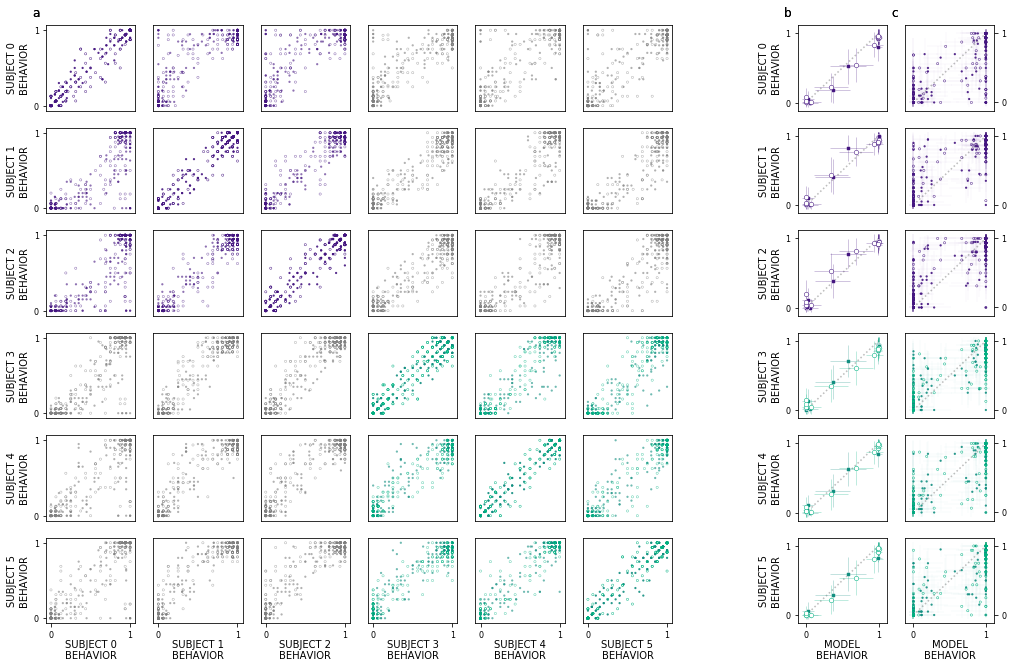

In [30]:
plt.figure(figsize=[17, 11])
model_subject_correspondence(monkey, df_reliability, model_performance)
if save_to_pdf: plt.savefig('subject_reliability.pdf', bbox_inches = "tight", format='pdf')

In [31]:
def generate_between_subject_distributions(df, df_m1): 
    
    distributions = {} 
    np.random.seed(random_seed)
    for ex in ['central_biased_morphs', '10pct_spaced_morphs']: 

        distributions[ex] = {} 
        e_df = df_reliability[df_reliability.experiment==ex]

        for target in ['image', 'percent']: 

            distributions[ex][target] = {} 
            mdata = df_m1[df_m1.experiment==ex].groupby(target).mean().choice.values


            for si in df.subject.unique(): 

                betweensubjects = {} 
                modelsubjects = [] 
                has_model_data = 0 

                # get reliability scores for all subject with si 
                for sj in [j for j in df.subject.unique() if j != si]: 

                    ij_distribution = [] 

                    # iterate over random split halves 
                    for itrtn in df_reliability.iteration.unique(): 

                        # get reliability for iteration
                        i_it = e_df[e_df.iteration==itrtn]
                        # decide which random split to use
                        isplit = np.random.randint(2)+1
                        # subject1 data for this iteration
                        s1 = i_it[i_it.split==isplit][i_it.subject==si].groupby(target).mean().choice.values
                        # subject2 data
                        s2 = i_it[i_it.split==isplit][i_it.subject==sj].groupby(target).mean().choice.values
                        #
                        ij_distribution.append( r2_score(s2, s1) ) 

                        if not has_model_data: 
                            modelsubjects.append(r2_score(s1, mdata))

                    has_model_data = 1

                    betweensubjects[sj] = ij_distribution

                sdata = e_df[e_df.subject==si].groupby(target).mean().choice.values

                distributions[ex][target][si] = {'subjects':betweensubjects, 
                                                'mdistribution': modelsubjects, 
                                                'mfit': r2_score(sdata, mdata)} 
    return distributions

In [32]:
distributions = generate_between_subject_distributions(monkey, model_performance)

In [33]:
def visualize_nonparametric_model_comparison_smaller(df, df_m1, distributions): 

    def BOUND(vector, MIN=0, MAX=1, SCALE=1): 
        return np.array([max(min(i*SCALE, MAX), MIN) for i in vector])

    resolution = 'subject'
    target = 'image'
    TARGET = 'percent'
    subjects = list( np.sort(df[resolution].unique()) )
    matrix = np.zeros([len(subjects), len(subjects)])
    ncols = 2 #len(elements)+3
    nrows = len(subjects)
    pointsize = 5
    ticksize  = 14
    labelsize = 14
    lettersize = 18
    
    onalpha   = .9
    offalpha  = .6
    linewidth = .5
    maxp = 101 
    minp = -1 

    
    LWIDTH=.5
    POINTSIZE = 40
    colorscheme = {'central_biased_morphs': {'CON':'#441580','PRC':'#128e80', 'model':'black'}, 
                   '10pct_spaced_morphs': {'CON':'#441580','PRC': '#01b282', 'model':'grey'}}

    Cs = {'CON':'#441580', 'PRC':'#01b282', 'model':'grey'}
    
    FIGURE = plt.figure(constrained_layout=True, figsize=[18, 13])
    widths = [3, 3]

    LAYOUT = FIGURE.add_gridspec(ncols=ncols, nrows=nrows, width_ratios=widths)
    
    for m in subjects: 
        
        for e in ['central_biased_morphs', '10pct_spaced_morphs']: 

            ae = df[(df.experiment==e)]
            m1e = df_m1[(df_m1.experiment==e)]

            x = ae[ae[resolution]==m].groupby(target).mean().choice.values
            X = ae[ae[resolution]==m].groupby(TARGET).mean().choice.values

            if   (m in [0,1,2]): color=colorscheme[e]['CON']
            elif (m in [3,4,5]): color=colorscheme[e]['PRC']

        kernal_width = .27
        for target in ['percent', 'image']: 
            # OG 
            #ax = FIGURE.add_subplot(LAYOUT[m, [1, 2][target=='image']])
            ax = FIGURE.add_subplot(LAYOUT[m, [0, 1][target=='image']])
            
            if target == 'percent': 
                plt.ylabel([m, 'SUBJECT %s\nBEHAVIOR'%(m+1)][resolution=='subject'], 
                           labelpad=5, fontsize=labelsize)

            sdata = distributions[e][target][m]
            js = list(sdata['subjects'])
            others = np.array([sdata['subjects'][i] for i in js]).flatten() 
            nice_pad = (max(others) - min(others))/3
            top_point = 0

            for j in js:         

                sdata = distributions[e][target][m]
                og_short = sdata['subjects'][j]
                density = gaussian_kde(og_short)
                xs = np.linspace(min(others)-nice_pad, max(others)+nice_pad, 200)
                density.covariance_factor = lambda : kernal_width
                density._compute_covariance()
                top_point = max( max( density(xs) ), top_point) 

                if j in [0, 1, 2]: color = Cs['CON']
                if j in [3, 4, 5]: color = Cs['PRC']
                plt.plot(xs, density(xs), alpha=.7, color=color, )
                plt.fill_between(x=xs, y1=np.zeros(len(xs)), y2=density(xs), alpha=.1, color=color)

            mdistribution = sdata['mdistribution']
            m_density = gaussian_kde(mdistribution)
            xs = np.linspace(min(mdistribution)-nice_pad, max(mdistribution)+nice_pad, 200)
            m_density.covariance_factor = lambda : kernal_width
            m_density._compute_covariance()
            plt.plot(xs, m_density(xs), alpha=1, linestyle=':', color='grey') 
            plt.fill_between(x=xs, y1=np.zeros(len(xs)), y2=m_density(xs), alpha=.1, color='lightgrey')
            plt.plot(xs, np.zeros(len(xs)), alpha=1, linestyle=':', color='grey') 

            if target=='image': 
                plt.xlim(.51, .911)
            else:
                plt.xlim(.8, 1.00)

            turnoff = ['right', 'left', 'top', 'bottom']
            plt.yticks([], [])
            [ax.spines[i].set_visible(False) for i in turnoff]
            if m==0: 
                plt.text(0, 1.1, ['a', 'b'][target=='image'], 
                         fontsize=lettersize, transform=ax.transAxes,)
            if m<5: 
                plt.xticks([],[]) 

            if (m==0)&(target=='percent'): 

                plt.plot([], [], alpha=1, color=Cs['CON'], label='prc-intact')
                plt.plot([], [], alpha=1, color=Cs['PRC'], label='prc-lesion')
                plt.plot([], [], alpha=1, color='grey', label='vvs model', linestyle=':') 
                plt.legend(loc=2, framealpha=0, fontsize=16)

            if m == 5: 
                labelname = ['Morph-level', 'Image-level'][target=='image']
                plt.xlabel('%s Correspondence'%labelname, labelpad=20, fontsize=20)
                plt.xticks(fontsize=ticksize)
                xtickslocs = ax.get_xticks()
                plt.xticks(xtickslocs[2:], np.round(xtickslocs[2:],2)) 

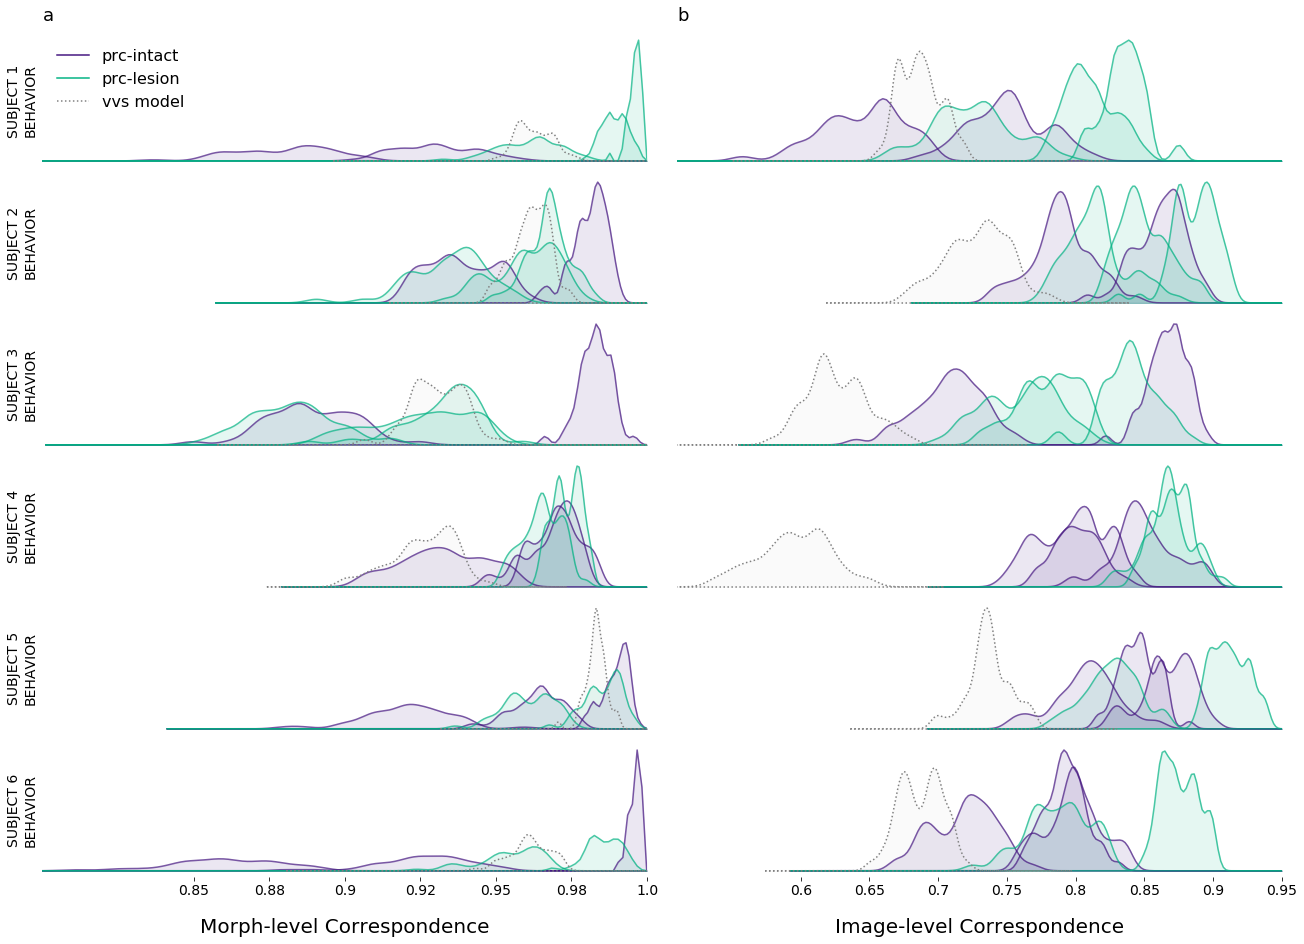

In [34]:
visualize_nonparametric_model_comparison_smaller(monkey, model_performance, distributions)
if save_to_pdf: plt.savefig('subjectlike_distributions.pdf', bbox_inches = "tight", format='pdf')

# supplement

In [35]:
def show_model_performance_tight(df, df_m, input_type='model'): 
    
    nice_names = {'10pct_spaced_morphs': '10% Spaced Morphs', 
     'central_biased_morphs': 'Central Biased Morphs', 
     'masked_morphs': 'Masked Morphs', 
     'crossed_morphs': 'Crossed Morphs', 
    }
        
    colorscheme = {'CON':'#441580',
               'CON':'#7123d4',
               'PRC':'#01b282', 
               'model':'black'}

    LR = LogisticRegression(solver='lbfgs')
    iplot=1
    
    def colorFader(c1,c2,mix=0): 
        # https://stackoverflow.com/questions/25668828/how-to-create-colour-gradient-in-python
        c1=np.array(mpl.colors.to_rgb(c1))
        c2=np.array(mpl.colors.to_rgb(c2))
        return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

    lcolors = {'PRC': colorscheme['PRC'], 
               'CON': colorscheme['CON'], 
               'model':'black'}
    
    lesion_groups = ['CON', 'PRC']
    naming = {'CON':'PRC Intact', "PRC":'PRC Lesion', }
    
    for e in nice_names:

        res = 'group'
        target = 'percent'
        alpha=1
        s = 60

        for group in ['CON', "PRC"]: 
            
            ax = plt.subplot(1, len(lesion_groups)+2, iplot)
            
            igroup = df[(df[res]==group)&(df.experiment==e)]
            imodel = df_m[df_m.experiment==e].groupby(target, as_index=False)
            igroup = igroup.groupby(target, as_index=False)

            plt.scatter(x=imodel.mean().choice.values, 
                        y=igroup.mean().choice, 
                        facecolor=colorscheme[group],
                        edgecolor='black', alpha=1, s=s, 
                        linewidth=1, label=naming[group], zorder=1)

            EB = plt.errorbar(x=imodel.mean().choice.values, 
                              y=igroup.mean().choice, 
                              xerr=(imodel.std().choice.values)/2, 
                              yerr=(igroup.std().choice.values)/2,
                              color=colorscheme[group], linestyle='', 
                              alpha=.3, 
                              elinewidth=1, 
                              zorder=-1) 

            [EB[-1][i].set_linestyle('-') for i in [0, 1]]

           
        plt.plot([0, 1], [0, 1], color='grey', linestyle='--', linewidth=.5, zorder=-2, alpha=.3)
        plt.legend(framealpha=0, title='Primate Group', title_fontsize=11, fontsize=11) 
        plt.xlim([-.15, 1.15])
        plt.ylim([-.15, 1.15])
        plt.title('Experiment %d'%iplot, y=1.05)
        
        #if e == df.experiment.unique()[-1]: 
        if input_type == 'model': 
            plt.xlabel('VVS Model Performance', labelpad=10, fontsize=15, )
        else: 
            plt.xlabel('Pixel-level Performance', labelpad=10, fontsize=15, )
        
        if iplot == 1: 
            plt.ylabel('Primate Behavior', labelpad=10, fontsize=15)
        
        #if iplot ==4: 
            #plt.title('Model Correspondence with Group Behavior', y=1.05)
        iplot+=1

In [36]:
pixel_performance = determine_model_performance_main(monkey, load_representations('pixels'), n_iterations)

loaded pixel representations
012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849

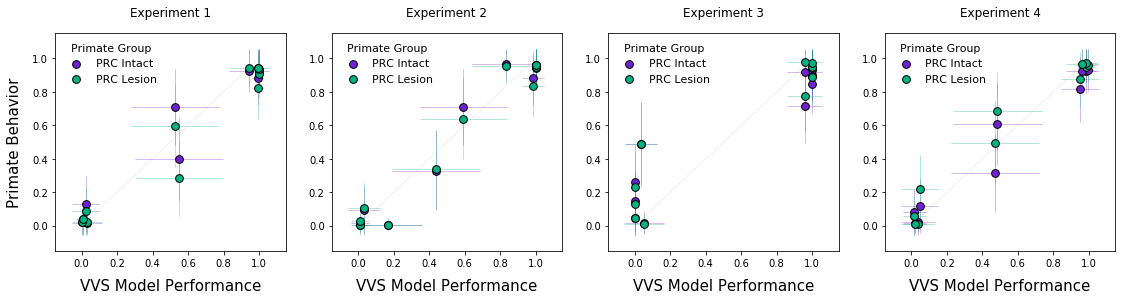

In [37]:
plt.figure(figsize=[19, 4])
show_model_performance_tight(monkey, pixel_performance)
if save_to_pdf: plt.savefig('stimulus_colinearity.pdf', bbox_inches = "tight", format='pdf')

In [38]:
def build_conservative_model(df, representations, n_iterations):
    
    def get_image_identity(i): 
        return i[i.find('img')+3:i.find('img')+6]
    def make_column(x, test_df): 
        return np.repeat(x, len(test_df))

    np.random.seed(123)

    searchparams = {'C':[10**i for i in range(-3, 3, 1)]}

    train_test_ratio = 4/5
    analysis_level = 'image'
    target = 'ground_truth'
    LINEAR_MODEL = LogisticRegression(penalty='l1', class_weight='balanced', solver='liblinear', max_iter=5000)
    mask_indices = get_masked_indices()   
    df_model = pandas.DataFrame()

    naming = {
        'Exp2_central_bias': 'central_biased_morphs', 
        'Exp4_crossed_morphs': 'crossed_morphs', 
        'Exp1_linear_distribution': '10pct_spaced_morphs',
        'Exp3_masked_morphs': 'masked_morphs', 
        'central_biased_morphs': 'Exp2_central_bias',
        'crossed_morphs':'Exp4_crossed_morphs', 
        '10pct_spaced_morphs':'Exp1_linear_distribution',
        'masked_morphs':'Exp3_masked_morphs'}

    for i_test in df.experiment.unique():

        print( '\n', i_test )
        e_df = df[df.experiment==i_test]

        # model representations
        if i_test == 'masked_morphs': 
            X = [representations[naming[i_test]][i] for i in mask_indices]
        else: 
            X = [representations[naming[i_test]][i] for i in representations[naming[i_test]].keys() ]

        e_df['L'] = np.array([get_image_identity(i) for i in list( e_df.image.values )]) 

        labels = np.unique(e_df['L']) 

        for i_iteration in range(n_iterations):

            print( i_iteration, end = '')

            if i_test == 'crossed_morphs': 
                # we have to add an additional precaution because of the co-linearity in this experiment
                TRAIN_SET = [np.arange(10*i, 10 + 10*i) for i in range(4)]
                TEST_SET  = TRAIN_SET.pop(np.random.randint(len( TRAIN_SET )))
                train = e_df[ [i in labels[np.array( TRAIN_SET) ] for i in e_df.L.values] ] 
                test  = e_df[ [i in labels[np.array( TEST_SET) ] for i in e_df.L.values] ] 
            else: 
                random_order = np.random.permutation(labels)
                i_split = int(len(random_order)*(train_test_ratio))
                train = e_df[ [i in random_order[:i_split] for i in e_df.L.values] ] 
                test  = e_df[ [i in random_order[i_split:] for i in e_df.L.values] ] 

            # only select each image once
            train = train.groupby('image', as_index=False).mean()
            test  = test.groupby('image', as_index=False).mean()

            # extract representations for the train test split
            x_train = [X[int(i-1)] for i in train.image_id.values ]
            x_test  = [X[int(i-1)] for i in test.image_id.values ]

            clf = GridSearchCV(LINEAR_MODEL, searchparams,  cv=4, iid=False,)

            clf.fit(x_train, train[target].values)

            model_predictions = clf.best_estimator_.predict(x_test)
            
            if 0: 
                print('analysis done')
                train_scores, valid_scores = validation_curve(
                    svm.SVC(
                        class_weight='balanced', 
                        kernel='linear'), 
                        x_train, 
                        train[target].values, 
                        param_name="C",
                        param_range=searchparams['C'],
                        cv=4)
                for i in range(len(searchparams['C'])): 
                    plt.scatter( np.repeat(i, train_scores.shape[1]), train_scores[i,:], color='black', alpha=.5)
                    plt.scatter( np.repeat(i, valid_scores.shape[1])+.1, valid_scores[i,:], color='red', alpha=.5)

                plt.plot( train_scores.mean(1), color='black', label='train') 
                plt.plot( valid_scores.mean(1), color='red', label='test') 
                plt.legend()
                plt.xticks(range(len( searchparams['C'])), searchparams['C'])
                plt.show()        
                print('visualization done')


            # bookkeeping
            i_df = pandas.DataFrame({
                        'group': make_column('model', test), 
                        'experiment': make_column(i_test, test),
                        'iteration': make_column(i_iteration, test), 
                        'percent': test.percent.values, 
                        'image_id': test.image_id.values, 
                        'image': test.image.values, 
                        'ground_truth': 1 * (test.percent.values >= 50),
                        'analysis_level': make_column(analysis_level, test), 
                        'target': make_column(target, test), 
                        'choice': model_predictions, 
                        'correct': (np.array(model_predictions)>=.5) == (1*(test.percent.values >= 50)), 
                        'y': test[target].values
                        })

            df_model = df_model.append(i_df, ignore_index=True)

    return df_model

In [39]:
pixel_performance_conservative = build_conservative_model(monkey, load_representations('pixels'), n_iterations)

loaded pixel representations

 central_biased_morphs
012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849
 10pct_spaced_morphs
012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849
 masked_morphs
012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849
 crossed_morphs
012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849

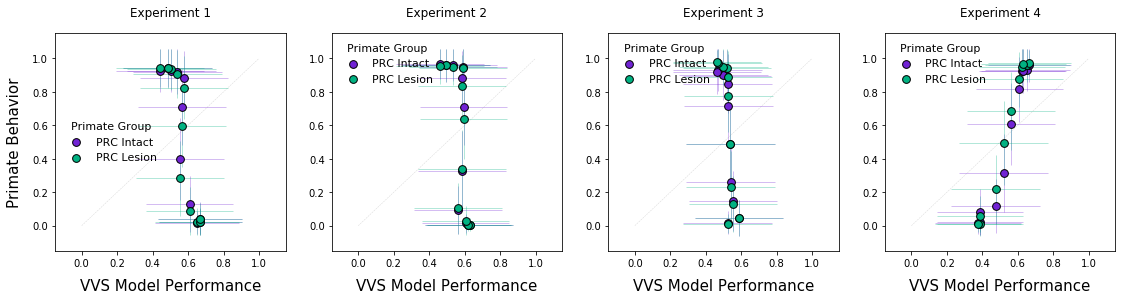

In [40]:
plt.figure(figsize=[19, 4])
show_model_performance_tight(monkey, pixel_performance_conservative)
if save_to_pdf: plt.savefig('pixel_failure.pdf', bbox_inches = "tight", format='pdf') 

In [41]:
model_performance_conservative = build_conservative_model(monkey, model, n_iterations)


 central_biased_morphs
012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849
 10pct_spaced_morphs
012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849
 masked_morphs
012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849
 crossed_morphs
012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849

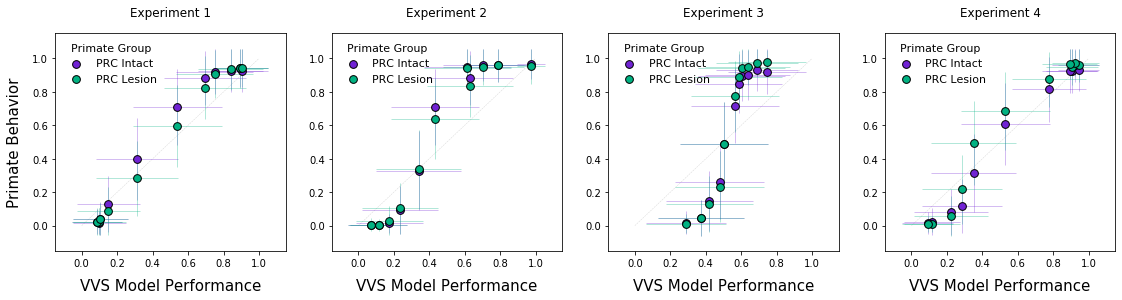

In [42]:
plt.figure(figsize=[19, 4])
show_model_performance_tight(monkey, model_performance_conservative)
if save_to_pdf: plt.savefig('model_robustness.pdf', bbox_inches = "tight", format='pdf') 